In [20]:
%matplotlib inline
from simulation import *
from math import *
from cmath import exp, phase
import numpy as np
import os
import matplotlib.pyplot as plt


golden_root_dir = "~/doc/github/simulation/resource/golden_data_latest/near_field/hyper_lith_kirchhoff/case1"
aerial = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_aerial_binary.txt"), delimiter='\t')
near_field = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_mag_binary.txt"), delimiter='\t')
pupil = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_pupil_intensity_binary.txt"), delimiter='\t')

In [21]:
wavelength = 13.0
NA = 0.9
pitch = 16
cd = 8
dx = 1
size = int(ceil(pitch / dx))
center_y, center_x = size // 2, size // 2

grid_info_2d = grid_info_2d_s.create_grid_info_bloch_mode([size, size], wavelength, 0.0, NA, [[-pitch/2, -pitch/2], [pitch/2, pitch/2]], 1e-6)
print(grid_info_2d)

freq, _ = grid_info_2d.fourier.step


* grid info                           
----------------------------------------
tilesize      :  [16,16]              
spatial start :  [-8,-8]              
spatial step  :  [1,1]                
fourier start :  [0,0]                
fourier step  :  [0.902778,0.902778]  
coords place  :  |*--|corner          



In [22]:
background = 1#polar_to_complex(0.86065, 0)
absorber = 0#polar_to_complex(0.0968, -2.675)
g2 = geo_manager([[
        [int(-cd/2/grid_info_2d.dbu), int(-cd/2/grid_info_2d.dbu)], 
        [int(-cd/2/grid_info_2d.dbu), int(cd/2/grid_info_2d.dbu)], 
        [int(cd/2/grid_info_2d.dbu), int(cd/2/grid_info_2d.dbu)], 
        [int(cd/2/grid_info_2d.dbu), int(-cd/2/grid_info_2d.dbu)]
    ]
])
g2 = geo_manager([[
        [int(-pitch/2/grid_info_2d.dbu), int(-pitch/8/grid_info_2d.dbu)], 
        [int(-pitch/2/grid_info_2d.dbu), int(pitch/8/grid_info_2d.dbu)], 
        [int(-pitch/4/grid_info_2d.dbu), int(pitch/8/grid_info_2d.dbu)], 
        [int(-pitch/4/grid_info_2d.dbu), int(-pitch/8/grid_info_2d.dbu)]
    ],[
        [int(pitch/4/grid_info_2d.dbu), int(-pitch/2/grid_info_2d.dbu)], 
        [int(pitch/4/grid_info_2d.dbu), int(pitch/2/grid_info_2d.dbu)], 
        [int(pitch/2/grid_info_2d.dbu), int(pitch/2/grid_info_2d.dbu)], 
        [int(pitch/2/grid_info_2d.dbu), int(-pitch/2/grid_info_2d.dbu)]
    ],

])
mask = binary_mask.create(absorber, background, grid_info_2d, g2.get_vertex())
complex_data_array = np.array(mask, dtype=np.complex64).reshape((size, size))
print(f"near field error = {np.max(complex_data_array - near_field)}")

near field error = 0j


In [23]:
fourier_shifted = np.fft.fftshift(np.fft.fft2(complex_data_array))

difract = diffraction(grid_info_2d)
print(difract.update_diffraction_source_points(fourier_shifted.flatten().tolist()))
pupil_intensity = difract.get_imaging_pupil_intensity([100, 100])

amp_error = [a - x for a, x in zip(pupil.flatten().tolist(), pupil_intensity)]
assert(max(np.abs(amp_error)) < grid_info_2d.dbu)

#  Sigma-X    Sigma-Y    Intensity   E-field-direction  DOP  Ellipticity  
---------------------------------------------------------------------------------
0  0          -0.902778  0.00320729  2.50448e-06        0    0            
1  -0.902778  0          0.054524    270                0    0            
2  0          0          0.0976562   90                 0    0            
3  0.902778   0          0.054524    90                 0    0            
4  0          0.902778   0.00320729  180                0    0            



In [24]:
def shift_phase(ix, iy, N, delta_x=0.5, delta_y=0.5):
    return np.exp(-2j * np.pi * (ix * delta_x / N + iy * delta_y / N))

desired_orders = get_diffraction_order(grid_info_2d)
print(f"保留的衍射级次: {desired_orders}")

# TE = np.zeros_like(fourier_shifted)
TE = np.zeros((40, 40), dtype=np.complex64)
TM = np.zeros_like(TE)

保留的衍射级次: [[0,-1],[-1,0],[0,0],[1,0],[0,1]]


In [25]:
def test3():
    def projection(is_TE, theta: float, fft_coef: complex, ix = 0, iy=0):
        # TE = TM 
        # return (fft_coef *  (exp(1j * theta).conjugate())) * exp(1j * theta)# *shift_phase(ix, iy, TE.shape[0])
        # return  (fft_coef.real * cos(theta) + fft_coef.imag *sin(theta)) * exp(1j * theta) 
        # 可以观察到TE/TM的压缩
        # c = (fft_coef *  (exp(1j * theta).conjugate()))
        # return (sqrt(1 - (freq * NA * (ix+iy))**2)  *c.real +  1j * c.imag) * exp(1j * theta) *shift_phase(ix, iy, TE.shape[0])
        te_y = 1
        tm_x = sqrt(1 - (freq * (ix+iy))**2)

        a, b = fft_coef.real, fft_coef.imag
        c,s = cos(theta), sin(theta)
        # return (tm_x * (a * c + b * s) + te_y * 1j *(b*c-a*s)) * exp(1j * theta) *shift_phase(ix, iy, TE.shape[0])

        return (tm_x * (a * c + 1 * b * s) + te_y * 1j *(b*c-a*s)) * exp(1j * theta) *shift_phase(ix, iy, TE.shape[0])

        # 条状直线
        # return abs(fft_coef) * cos(theta) * exp(1j * theta) *shift_phase(ix, iy, TE.shape[0])
        # 条状直线
        # if is_TE:
        #     return fft_coef * (0 * cos(theta) + sqrt(1 - (freq * (ix+iy))**2) * sin(theta))  * shift_phase(ix, iy, TE.shape[0])
        # else:
        #     return fft_coef * (1 * cos(theta) + 0 * sin(theta))  * shift_phase(ix, iy, TE.shape[0])
    for order_x, order_y in desired_orders:
        posy, posx = TE.shape[0]//2 + order_y, TE.shape[1]//2 + order_x
        fft_coef = fourier_shifted[center_y + order_y, center_x + order_x]
        azimuth = atan2(order_y, order_x)
        
        TE[posy, posx] = projection(True,azimuth + 0.5*pi, fft_coef, order_x, order_y )
        TM[posy, posx] = projection(False,azimuth , fft_coef, order_x, order_y )

test3()

In [26]:

reconstructed_data_TE = np.fft.ifft2(np.fft.ifftshift(TE))
reconstructed_data_TE = np.real(reconstructed_data_TE * np.conj(reconstructed_data_TE))
reconstructed_data_TE_1 = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_aerial_binary_TE.txt"), delimiter='\t')

reconstructed_data_TM = np.fft.ifft2(np.fft.ifftshift(TM))
reconstructed_data_TM = np.real(reconstructed_data_TM * np.conj(reconstructed_data_TM))
reconstructed_data_TM_1 = np.loadtxt(os.path.join(os.path.abspath(os.path.expanduser(golden_root_dir)), "thin_mask_2d_aerial_binary_TM.txt"), delimiter='\t')

reconstructed_data_magnitude = (reconstructed_data_TE + reconstructed_data_TM) / 2


In [27]:
def plotnx1(im_list, name_list, n = 4):
    fig, axes = plt.subplots(1, n, figsize=(12, 6))
    def sub_plot(n, data, name):
        fig.colorbar(axes[n].imshow(data, cmap='viridis'), ax=axes[n], label='')
        axes[n].set_title(name)
        axes[n].axis('off')
    for i in range(n):
        sub_plot(i, im_list[i], name_list[i])
    plt.tight_layout() 
    plt.show()
def normlization(golden, input):
    return input * np.max(golden)/np.max(input)
def normlization_diff(golden, input):
    return golden - normlization(golden, input) 

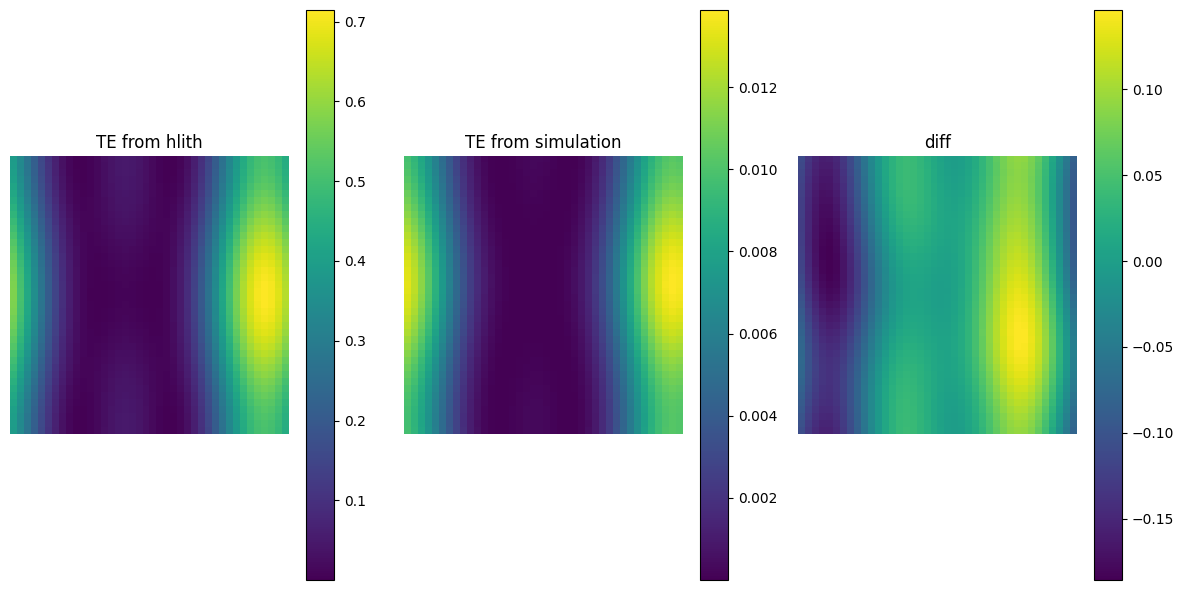

In [28]:
plotnx1([reconstructed_data_TE_1, reconstructed_data_TE, normlization_diff(reconstructed_data_TE_1, reconstructed_data_TE)], 
        ["TE from hlith", "TE from simulation", "diff"], 3
)

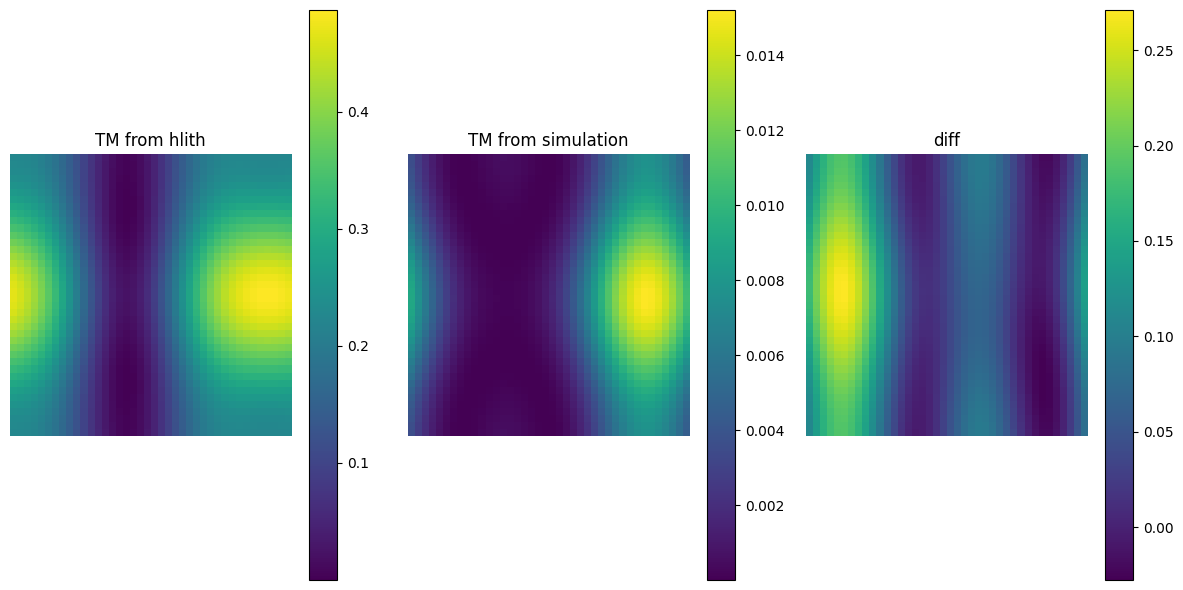

In [29]:
plotnx1([reconstructed_data_TM_1, reconstructed_data_TM, normlization_diff(reconstructed_data_TM_1, reconstructed_data_TM)], 
        ["TM from hlith", "TM from simulation", "diff"], 3
)

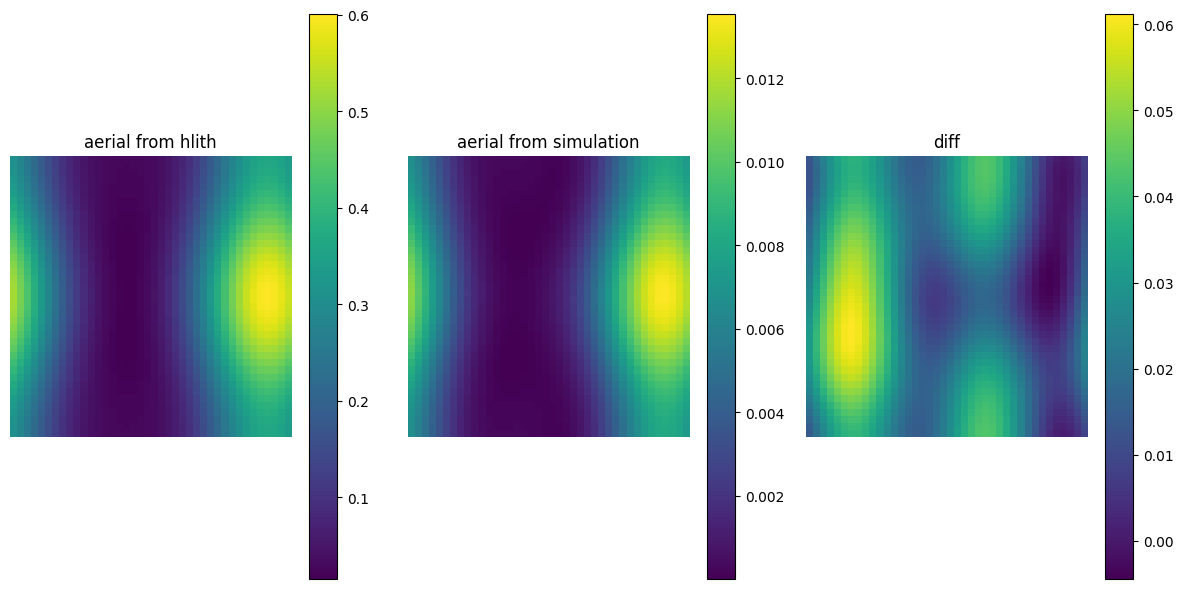

In [30]:
plotnx1([aerial, reconstructed_data_magnitude, normlization_diff(aerial, reconstructed_data_magnitude)], 
        ["aerial from hlith", "aerial from simulation", "diff"], 3
)

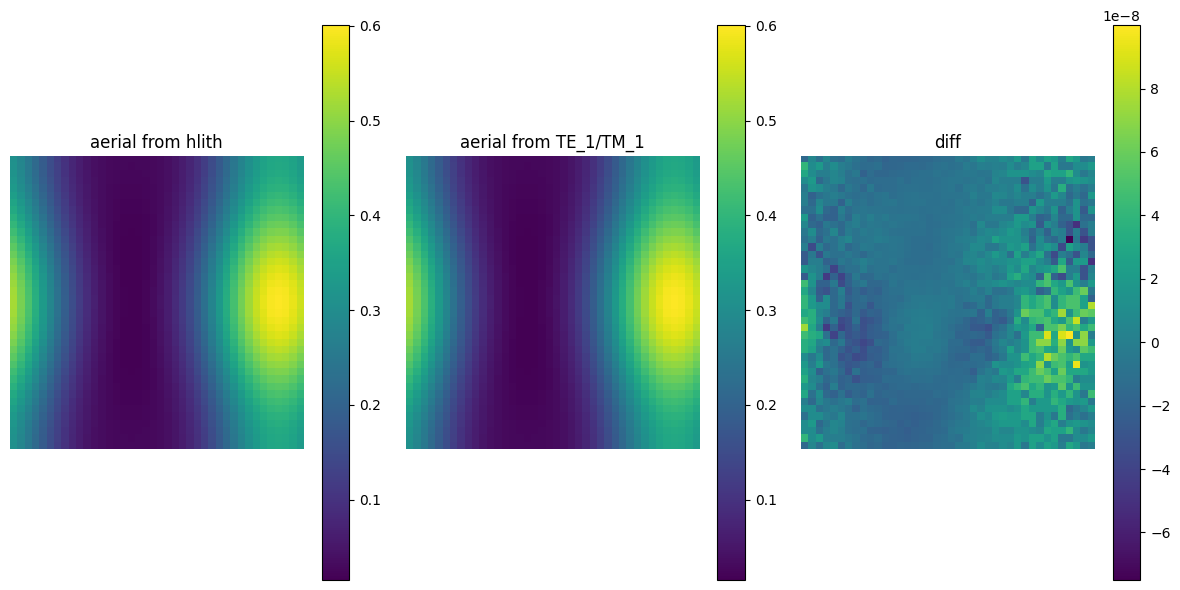

In [31]:
reconstructed_data_magnitude_1 = (reconstructed_data_TE_1 + reconstructed_data_TM_1) / 2
plotnx1([aerial, reconstructed_data_magnitude_1, reconstructed_data_magnitude_1 - aerial], 
        ["aerial from hlith", "aerial from TE_1/TM_1", "diff"], 3
)